# This notebook is an example notebook to inference the latent diffusion model.

In [10]:
import argparse, os, sys, glob
sys.path.append(os.getcwd()+"/ldm")
from omegaconf import OmegaConf
from PIL import Image, ImageDraw, ImageFilter
from tqdm import tqdm
import numpy as np
import torch
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from torch.utils.data import Dataset, DataLoader
import os, sys, yaml, pickle, shutil, tarfile, glob
import cv2
import albumentations
import numpy as np
import torchvision.transforms.functional as TF
from omegaconf import OmegaConf
from functools import partial
from PIL import Image
from tqdm import tqdm
import os
import torch
from torch.utils.data import Dataset, Subset
import random
import matplotlib.pyplot as plt

import torchvision.transforms as T
transform_PIL = T.ToPILImage()

import uuid

In [11]:
# config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# yaml_path="/mayo_atlas/home/m288756/latent-diffusion-inpainting/ldm/models/ldm/inpainting_big/config.yaml"
# model_path="ldm/models/ldm/inpainting_big/last.ckpt"
# model_path="/mayo_atlas/home/m288756/latent-diffusion-inpainting/logs/checkpoints/last.ckpt"

yaml_path="/mayo_atlas/home/m288756/stable-diffusion/models/ldm/inpainting_big/config.yaml"
# model_path="/mayo_atlas/home/m288756/stable-diffusion/models/ldm/inpainting_big/last.ckpt"
# model_path="/mayo_atlas/home/m288756/latent-diffusion-inpainting/ldm/models/ldm/inpainting_big/new_model.ckpt"
# model_path="/mayo_atlas/home/m288756/stable-diffusion/logs2/checkpoints/last.ckpt"
model_path="/mayo_atlas/home/m288756/stable-diffusion/logs/checkpoints/last2.ckpt"
# model_path="/home/m288756/stable-diffusion/someCheckpoints/last1million1epoch.ckpt"

In [12]:
##create model
def create_model(device):
    
    #load config and checkpoint
    config = OmegaConf.load(yaml_path)
    config.model['params']['ckpt_path']=model_path
    
    model = instantiate_from_config(config.model)
    sampler = DDIMSampler(model)
    model = model.to(device)

    return model,sampler

In [13]:
def random_rectangle_mask(image):
    # Create a copy of the original image
    masked_image = image.copy()
    image_x, image_y = image.size
    
    # width = random.randint(70, 150)
    width = random.randint(200, 300)
    print(width)
    height = int(width * random.uniform(0.7, 1.5))
    
    
    # Create a black background mask
    mask = Image.new('L', (image_x, image_y), 0)
    draw = ImageDraw.Draw(mask)

    # Randomly generate the coordinates for the top-left and bottom-right corners of the rectangle
    x1 = random.randint(0, image.size[0] - width)
    y1 = random.randint(0, image.size[1] - height)
    x2 = x1 + width
    y2 = y1 + height

    # Draw a white rectangle on the mask
    draw.rectangle([x1, y1, x2, y2], fill=255)

    # Apply the mask to the original image
    masked_image.paste(Image.new('RGB', (image_x, image_y), (0, 0, 0)), mask=mask)

    return image, mask, masked_image


In [14]:
def process_data(image,mask):

    # creating a 3 dimensional mask
    mask = np.array(mask)
    mask = np.expand_dims(mask, axis=2)

    # normalzie and transform the image into tensor
    image = np.array(image.convert("RGB"))
    image = image.astype(np.float32) / 255.0#
    image = image[None].transpose(0,3,1,2)
    image = torch.from_numpy(image)

    
    # normalzie and transform the mask into tensor
    mask = mask.astype(np.float32) / 255.0#
    mask[mask < 0.1] = 0
    mask[mask >= 0.1] = 1
    mask = mask[None].transpose(0,3,1,2)

    
    # produce the masked image by subtraction
    mask = torch.from_numpy(mask)
    masked_image = (1 - mask) * image
    
    print(f'image shape {image.shape}')
    print(f'mask shape {mask.shape}')
    print(f'masked_image shape {masked_image.shape}')
    print("------------------")


    batch = {"image_tensor": image, "mask_tensor": mask, "masked_image_tensor": masked_image}
    for k in batch:
        batch[k] = batch[k] * 2.0 - 1.0

    return batch

In [15]:
model,sampler=create_model(device)

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 387.25 M params.
Keeping EMAs of 418.
making attention of type 'none' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'none' with 512 in_channels
Using first stage also as cond stage.
Restored from /mayo_atlas/home/m288756/stable-diffusion/logs/checkpoints/last1.ckpt with 0 missing and 0 unexpected keys


In [16]:
load_image=Image.open("/mayo_atlas/home/m288756/stable-diffusion/data/oneImage/TCGA-22-A5C4-01Z-00-DX1.54058689-5CA5-4F92-B18A-86208C24C87D_18432_47104.jpg").resize((512,512))

In [17]:
image,mask,masked_image=random_rectangle_mask(load_image)

289


In [18]:
batch=process_data(image,mask)

image shape torch.Size([1, 3, 512, 512])
mask shape torch.Size([1, 1, 512, 512])
masked_image shape torch.Size([1, 3, 512, 512])
------------------


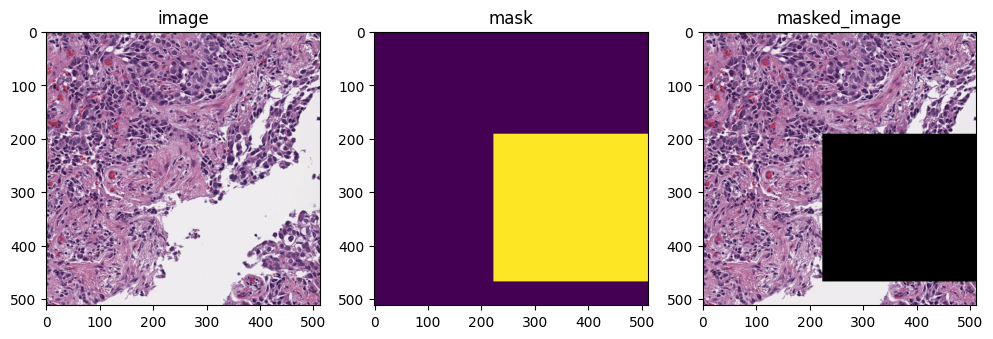

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create a 1x3 grid for displaying 3 images

# Display each image on a separate subplot
axes[0].imshow(image)
axes[0].set_title('image')

axes[1].imshow(mask)
axes[1].set_title('mask')

axes[2].imshow(masked_image)
axes[2].set_title('masked_image')

plt.show()

image shape torch.Size([1, 3, 512, 512])
mask shape torch.Size([1, 1, 512, 512])
masked_image shape torch.Size([1, 3, 512, 512])
------------------
Data shape for DDIM sampling is (1, 3, 128, 128), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:04<00:00, 10.39it/s]


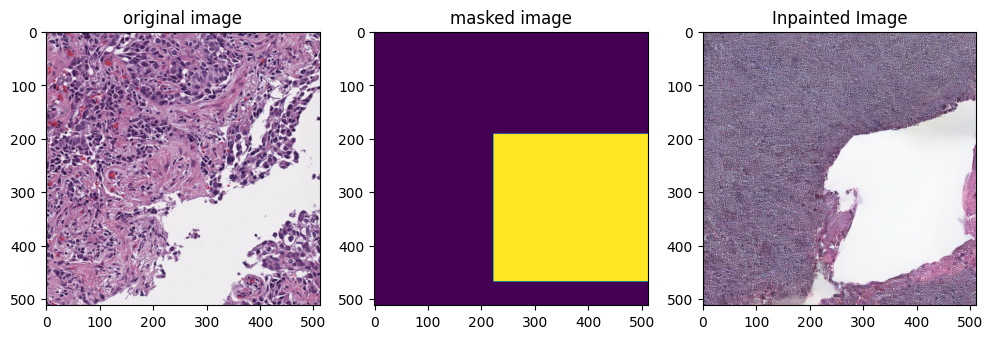

In [26]:
##Inference

# convert PIL image into input Torch Tensor
batch=process_data(image,mask)
image_tensor=batch["image_tensor"]
mask_tensor=batch["mask_tensor"]
masked_image_tensor=batch["masked_image_tensor"]


# encode masked image and concat downsampled mask
c = model.cond_stage_model.encode(masked_image_tensor.to(device))

# the mask is frst being downsampled
cc = torch.nn.functional.interpolate(mask_tensor.to(device),
                                    size=c.shape[-2:])
# concat the masked image and downsampled mask
c = torch.cat((c, cc), dim=1)
shape = (c.shape[1]-1,)+c.shape[2:]

# shape = (3, 128, 128)
# c.shape
# diffusion process
samples_ddim, _ = sampler.sample(S=50,
                             conditioning=c,
                             batch_size=c.shape[0],
                             shape=shape,
                             verbose=False)


# decode the latent vector (output)
x_samples_ddim = model.decode_first_stage(samples_ddim)


# denormalize the output
predicted_image_clamped = torch.clamp((x_samples_ddim+1.0)/2.0,
                            min=0.0, max=1.0)

output_PIL=transform_PIL(predicted_image_clamped[0])

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create a 1x3 grid for displaying 3 images``

# Display each image on a separate subplot
axes[0].imshow(image)
axes[0].set_title('original image')

axes[1].imshow(mask)
axes[1].set_title('masked image')

axes[2].imshow(output_PIL)
axes[2].set_title('Inpainted Image')

plt.show()

In [21]:
output_PIL=transform_PIL(predicted_image_clamped[0])

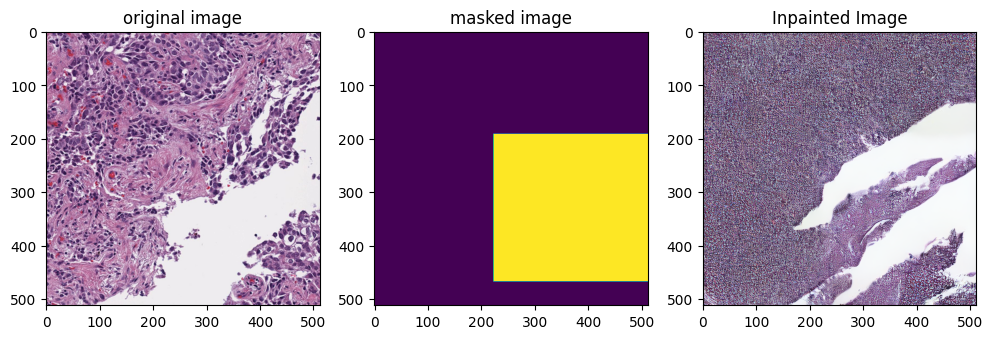

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create a 1x3 grid for displaying 3 images``

# Display each image on a separate subplot
axes[0].imshow(image)
axes[0].set_title('original image')

axes[1].imshow(mask)
axes[1].set_title('masked image')

axes[2].imshow(output_PIL)
axes[2].set_title('Inpainted Image')

plt.show()